# Anime Recommendation System
#### Alejandra Avitia-Davila, Crystal Feng, Simon Chau, and Tyler Lafond

In [64]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

animes_df = pd.read_csv("animes.csv")
animes_df = animes_df.drop(columns=['synopsis', 'aired', 'episodes', 'members', 'img_url', 'link']).drop_duplicates()
profiles_df = pd.read_csv("profiles.csv")
profiles_df = profiles_df.drop(columns = ['gender', 'birthday', 'link']).drop_duplicates()
print(animes_df.head())
print(profiles_df.head())
print(len(profiles_df.index))
#profiles_df_2 = profiles_df.head(5)
animes_df.to_csv("clean_animes.csv", index=False)
profiles_df.to_csv("clean_profiles.csv", index=False)

     uid                             title  \
0  28891           Haikyuu!! Second Season   
1  23273           Shigatsu wa Kimi no Uso   
2  34599                     Made in Abyss   
3   5114  Fullmetal Alchemist: Brotherhood   
4  31758  Kizumonogatari III: Reiketsu-hen   

                                               genre  popularity  ranked  \
0  ['Comedy', 'Sports', 'Drama', 'School', 'Shoun...         141    25.0   
1  ['Drama', 'Music', 'Romance', 'School', 'Shoun...          28    24.0   
2  ['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...          98    23.0   
3  ['Action', 'Military', 'Adventure', 'Comedy', ...           4     1.0   
4   ['Action', 'Mystery', 'Supernatural', 'Vampire']         502    22.0   

   score  
0   8.82  
1   8.83  
2   8.83  
3   9.23  
4   8.83  
           profile                                    favorites_anime
0   DesolatePsyche  ['33352', '25013', '5530', '33674', '1482', '2...
1        baekbeans  ['11061', '31964', '853', '20583', '918'

***Defining functions:***
- genre_list(anime_uid)
- anime_list(profile)

In [2]:
def genre_list(anime_uid):
    if(anime_uid == ""): return []
    anime_uid = int(anime_uid)
    if(len(animes_df.loc[animes_df["uid"] == anime_uid]) == 0): return []
    raw_genres = animes_df.loc[animes_df["uid"] == anime_uid]["genre"].array[0]
    genres = raw_genres.strip("][").replace("'", "").split(", ")
    for genre in genres:
        genre = genre.replace(" ", "")
    return genres

#print(genre_list(33352))

def anime_list(profile):
    if(profile > len(profiles_df.index)) : return []
    raw_favorites = profiles_df.iloc[profile]["favorites_anime"]
    favorites = raw_favorites.strip("][").replace("'", "").split(", ")
    for anime in favorites:
        anime = anime.replace("'", "")
    return favorites
    
#print(anime_list(0))

def anime_name(anime_uid):
    if(anime_uid == ""): return ""
    anime_uid = int(anime_uid)
    if(len(animes_df.loc[animes_df["uid"] == anime_uid]) == 0): return ""
    return animes_df.loc[animes_df["uid"] == anime_uid]["title"].array[0]

#print(anime_name(28891))

def gen_frequencies(anime_list):
    curr_list = []
    for anime_uid in anime_list:
        uid = anime_uid.replace("'", "")
        curr_list += genre_list(uid)
    num_genres = len(curr_list)
    genre_series = pd.Series(curr_list)
    genre_frequencies = genre_series.value_counts() / num_genres
    return genre_frequencies

### Computing frequencies for profiles

In [ ]:
#commented out and saved to csv since this process takes a while

#df_profile_freq = pd.DataFrame() #index is same as profile_df_index
#for profile in profiles_df.index:
#    favorites = anime_list(profile)
#    genres = []
#    for anime in favorites:
#        genres += genre_list(anime)
#    genre_series = pd.Series(genres)
#    num_genres = len(genres)
#    genre_frequencies = genre_series.value_counts() / num_genres
#    df_profile_freq = df_profile_freq.append(genre_frequencies, ignore_index=True)
#df_profile_freq = df_profile_freq.drop(columns=[""])
#df_profile_freq = df_profile_freq.fillna(0)
#df_profile_freq.to_csv("profile_genres.csv", index=False)

### EDA

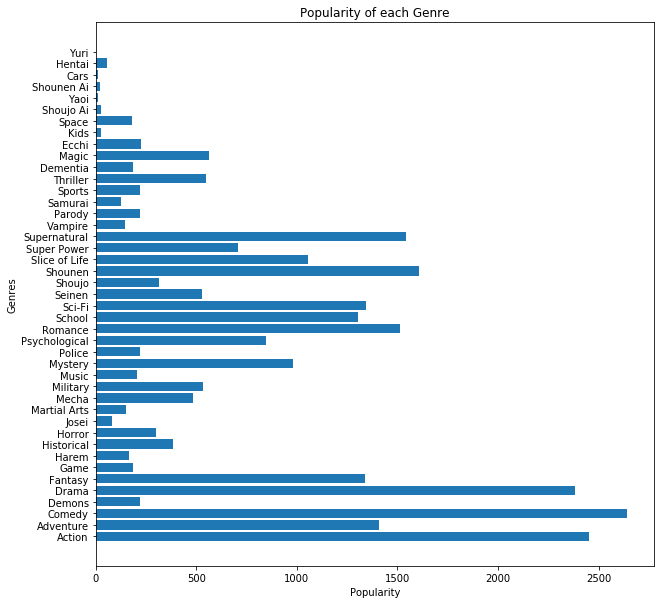

The 5 most popular anime genres are: Comedy, Action, Drama, Shounen, and Supernatural


In [3]:
df_freq = pd.read_csv("profile_genres.csv")
genres = df_freq.columns
sums=[]
for genre in genres:
    curr = df_freq[genre].sum()
    sums.append(curr)

plt.figure(figsize=(10,10))
plt.barh(genres, sums)
plt.ylabel("Genres")
plt.xlabel("Popularity")
plt.title("Popularity of each Genre")
plt.show()

print("The 5 most popular anime genres are: Comedy, Action, Drama, Shounen, and Supernatural")

### PCA Decomposition on profile genre frequencies

In [4]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(df_freq)
print("Explained variation per principal component:", pca.explained_variance_ratio_)
cumulative_variance = sum(pca.explained_variance_ratio_) 
print('Cumulative variance explained by 5 principal components: ', cumulative_variance)

Explained variation per principal component: [0.30673005 0.11921416 0.08733801 0.0552943  0.05119796]
Cumulative variance explained by 5 principal components:  0.6197744840853427


### Using Elbow Method with WCSS to determine optimal k-value 

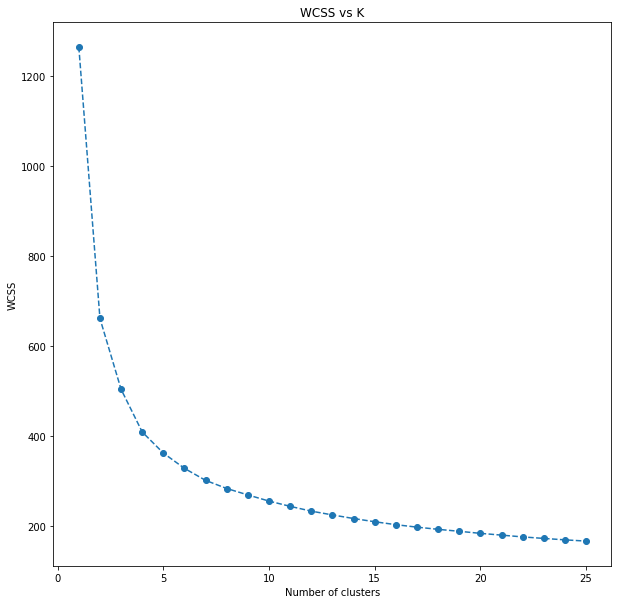

In [5]:
wcss = []
for i in range(1, 26):
    k_means = KMeans(n_clusters=i, init='k-means++', random_state=20)
    k_means.fit(pca_result)
    wcss.append(k_means.inertia_)

    
plt.figure(figsize=(10,10))
plt.plot(range(1,26), wcss, marker="o", linestyle='--')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("WCSS vs K")
plt.show()

In [6]:
optimal_k = 5
final_k_means = KMeans(n_clusters = optimal_k, init = "k-means++", random_state=20)
final_k_means.fit(pca_result)
df_pca_kmeans = pd.concat([profiles_df.reset_index(drop=True), pd.DataFrame(pca_result)], axis=1)
df_pca_kmeans.columns.values[-5:] = ["Component 1", "Component 2", "Component 3", "Component 4", "Component 5"]
df_pca_kmeans["Cluster"] = final_k_means.labels_
mapping = {0:'first', 1:"second", 2:"third", 3:"fourth", 4:"fifth"}
df_pca_kmeans["Cluster"] = df_pca_kmeans["Cluster"].map(mapping)

df_freq["Cluster"] = final_k_means.labels_
df_freq["Cluster"] = df_freq["Cluster"].map(mapping)

In [63]:
#print(df_pca_kmeans.head())
print(df_freq.head())
third_cluster = df_freq.loc[df_freq["Cluster"] == 'third']

     Action  Adventure    Comedy    Demons     Drama   Fantasy      Game  \
0  0.078431   0.078431  0.088235  0.009804  0.088235  0.049020  0.009804   
1  0.106383   0.042553  0.127660  0.000000  0.042553  0.063830  0.000000   
2  0.063830   0.021277  0.063830  0.000000  0.106383  0.063830  0.000000   
3  0.125000   0.041667  0.125000  0.000000  0.041667  0.083333  0.000000   
4  0.000000   0.020833  0.166667  0.000000  0.083333  0.000000  0.041667   

      Harem  Historical    Horror  ...  Ecchi  Kids  Space  Shoujo Ai  Yaoi  \
0  0.009804    0.019608  0.019608  ...    0.0   0.0    0.0        0.0   0.0   
1  0.021277    0.021277  0.000000  ...    0.0   0.0    0.0        0.0   0.0   
2  0.000000    0.021277  0.021277  ...    0.0   0.0    0.0        0.0   0.0   
3  0.000000    0.000000  0.000000  ...    0.0   0.0    0.0        0.0   0.0   
4  0.000000    0.000000  0.000000  ...    0.0   0.0    0.0        0.0   0.0   

   Shounen Ai  Cars  Hentai  Yuri  Cluster  
0         0.0   0.0    

### Using KNN to classify new user into a cluster

In [8]:
scaler = StandardScaler()
scaler.fit(df_pca_kmeans.drop(columns=['Cluster', 'profile', 'favorites_anime'], axis = 1))
scaled_features = scaler.transform(df_pca_kmeans.drop(columns=['Cluster', 'profile', 'favorites_anime'], axis = 1))
scaled_data = pd.DataFrame(scaled_features, columns = df_pca_kmeans.drop(columns=['Cluster', 'profile', 'favorites_anime'], axis = 1).columns)
scaled_data.head()
from sklearn.model_selection import train_test_split
x = scaled_data
y = df_pca_kmeans['Cluster']
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.4)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
model = KNeighborsClassifier(n_neighbors = 13)
model.fit(x_training_data, y_training_data)
#predictions = model.predict(x_test_data)
#error_rates = []
#for i in np.arange(1, 20):
 #   new_model = KNeighborsClassifier(n_neighbors = i)
  #  new_model.fit(x_training_data, y_training_data)
   # new_predictions = new_model.predict(x_test_data)
    #error_rates.append(np.mean(new_predictions != y_test_data))
%matplotlib inline
#plt.plot(error_rates)
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
#print(classification_report(y_test_data, predictions))
#print(confusion_matrix(y_test_data, predictions))

## Finding Recommendations 

In [50]:
user1 = ['37510', '38000', '30276', '552', '32998'] #action, shounen
user2 = ['1735', '813', '11757', '31964', '32281'] #action, fantasy, shounen, romance
user3 = ['5114', '1535', '2167', '22319', '120'] #fantasy, romance, military, mystery, horror, comedy

new_df_3 = pd.DataFrame()

new_df_3 = df_freq.append(gen_frequencies(user1), ignore_index=True)
new_df_3 = new_df_3.append(gen_frequencies(user2), ignore_index=True)
new_df_3 = new_df_3.append(gen_frequencies(user3), ignore_index=True)

new_df_3 = new_df_3.fillna(0)
new_df_3 = new_df_3.drop(columns=['Cluster'], axis=1)
new_df_3 = new_df_3.drop(new_df_3.index[:-3])
#print(new_df_3)
new_users_result = pca.transform(new_df_3)
out = list(model.predict(new_users_result))
#print(out)

cluster_3 = df_freq.loc[df_freq["Cluster"] == 'third']
cluster_2 = df_freq.loc[df_freq["Cluster"] == 'second']

#user 1:
dist1 = cluster_3.drop("Cluster", axis=1).sub(new_df_3.iloc[0], axis=1).pow(2).sum(axis=1).pow(.5)

dist2 = cluster_3.drop("Cluster", axis=1).sub(new_df_3.iloc[1], axis=1).pow(2).sum(axis=1).pow(.5)

dist3 = cluster_2.drop("Cluster", axis=1).sub(new_df_3.iloc[2], axis=1).pow(2).sum(axis=1).pow(.5)

neighbors_1 = dist1.nsmallest(5).index
neighbors_2 = dist2.nsmallest(5).index
neighbors_3 = dist3.nsmallest(5).index

In [62]:
#user 1 recommendations:
recommendation_1 = []
for user in neighbors_1:
    current_favorites = profiles_df.iloc[user]["favorites_anime"].strip("][").replace("'", "").split(", ")
    for i in current_favorites:
        if (i not in recommendation_1) and (i not in user1):
            recommendation_1.append(i)
    
for i in range(0, len(recommendation_1)):
    recommendation_1[i] = anime_name(recommendation_1[i])
    

recommendation_2 = []
for user in neighbors_2:
    current_favorites = profiles_df.iloc[user]["favorites_anime"].strip("][").replace("'", "").split(", ")
    for i in current_favorites:
        if (i not in recommendation_2) and (i not in user2):
            recommendation_2.append(i)
    
for i in range(0, len(recommendation_2)):
    recommendation_2[i] = anime_name(recommendation_2[i])
    
recommendation_3 = []
for user in neighbors_3:
    current_favorites = profiles_df.iloc[user]["favorites_anime"].strip("][").replace("'", "").split(", ")
    for i in current_favorites:
        if (i not in recommendation_3) and (i not in user3):
            recommendation_3.append(i)
    
for i in range(0, len(recommendation_3)):
    recommendation_3[i] = anime_name(recommendation_3[i])
    
print("User 1's recommendations:", recommendation_1, "\n")
print("User 2's recommendations:", recommendation_2, "\n")
print("User 3's recommendations:", recommendation_3, "\n")

User 1's recommendations: ['Mononoke Hime', 'Fate/Zero 2nd Season', 'Mob Psycho 100', 'Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare', 'Gintama°', 'One Piece', 'Baccano!', 'Tengen Toppa Gurren Lagann', 'Fate/Zero', 'Toradora!', 'Yuu☆Yuu☆Hakusho', 'Hunter x Hunter (2011)', 'Code Geass: Hangyaku no Lelouch', 'Cowboy Bebop', 'Black Lagoon', 'Gintama', 'Durarara!!', 'Kaze Tachinu', 'Noragami', 'Black Lagoon: The Second Barrage', 'Samurai Champloo', 'Baccano! Specials', 'Gankutsuou'] 

User 2's recommendations: ['Hunter x Hunter (2011)', 'Shingeki no Kyojin', 'Naruto', 'Akatsuki no Yona', 'Haikyuu!!', 'Ore Monogatari!!', 'Ansatsu Kyoushitsu 2nd Season', 'One Punch Man', 'One Piece', 'Shokugeki no Souma', 'No Game No Life', 'Boruto: Naruto Next Generations', 'Fairy Tail', 'Toradora!', 'Accel World', 'Bleach', 'Fairy Tail Movie 2: Dragon Cry', 'Koukyoushihen Eureka Seven', 'Soul Eater', 'Medaka Box'] 

User 3's recommendations: ['Clannad: After Story', 'Durarara!!', 'Mahou Shoujo Mado